# Practical Application III: Comparing Classifiers

**Overview**: In this practical application, your goal is to compare the performance of the classifiers we encountered in this section, namely K Nearest Neighbor, Logistic Regression, Decision Trees, and Support Vector Machines.  We will utilize a dataset related to marketing bank products over the telephone.  



### Getting Started

Our dataset comes from the UCI Machine Learning repository [link](https://archive.ics.uci.edu/ml/datasets/bank+marketing).  The data is from a Portugese banking institution and is a collection of the results of multiple marketing campaigns.  We will make use of the article accompanying the dataset [here](CRISP-DM-BANK.pdf) for more information on the data and features.



### Problem 1: Understanding the Data

To gain a better understanding of the data, please read the information provided in the UCI link above, and examine the **Materials and Methods** section of the paper.  How many marketing campaigns does this data represent?

***The dataset collected is related to 17 campaigns that occurred between May 2008 and November 2010, corresponding to a total of 79354 contacts.***

### Problem 2: Read in the Data

Use pandas to read in the dataset `bank-additional-full.csv` and assign to a meaningful variable name.

In [181]:
import pandas as pd
import numpy as np
import seaborn as sns
import warnings
import matplotlib.pyplot as plt
import time
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, FunctionTransformer, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import make_column_selector, ColumnTransformer, make_column_transformer
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.metrics import mean_squared_error 
from sklearn.inspection import permutation_importance 
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score
from sklearn import set_config
from sklearn.linear_model import LogisticRegression, Ridge, Lasso
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.tree import DecisionTreeClassifier  
from sklearn.svm import SVC  
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.dummy import DummyClassifier
set_config(display="diagram")
warnings.filterwarnings('ignore')

In [182]:
df = pd.read_csv('data/bank-additional-full.csv', sep = ';')

In [183]:
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.10000,93.99400,-36.40000,4.85700,5191.00000,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.10000,93.99400,-36.40000,4.85700,5191.00000,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.10000,93.99400,-36.40000,4.85700,5191.00000,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.10000,93.99400,-36.40000,4.85700,5191.00000,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.10000,93.99400,-36.40000,4.85700,5191.00000,no


In [184]:
# Find out size of data
df.shape

(41188, 21)

### Problem 3: Understanding the Features


Examine the data description below, and determine if any of the features are missing values or need to be coerced to a different data type.


```
Input variables:
# bank client data:
1 - age (numeric)
2 - job : type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')
3 - marital : marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)
4 - education (categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')
5 - default: has credit in default? (categorical: 'no','yes','unknown')
6 - housing: has housing loan? (categorical: 'no','yes','unknown')
7 - loan: has personal loan? (categorical: 'no','yes','unknown')
# related with the last contact of the current campaign:
8 - contact: contact communication type (categorical: 'cellular','telephone')
9 - month: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')
10 - day_of_week: last contact day of the week (categorical: 'mon','tue','wed','thu','fri')
11 - duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.
# other attributes:
12 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
13 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
14 - previous: number of contacts performed before this campaign and for this client (numeric)
15 - poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')
# social and economic context attributes
16 - emp.var.rate: employment variation rate - quarterly indicator (numeric)
17 - cons.price.idx: consumer price index - monthly indicator (numeric)
18 - cons.conf.idx: consumer confidence index - monthly indicator (numeric)
19 - euribor3m: euribor 3 month rate - daily indicator (numeric)
20 - nr.employed: number of employees - quarterly indicator (numeric)

Output variable (desired target):
21 - y - has the client subscribed a term deposit? (binary: 'yes','no')
```



***Understanding the Data***

1. With df.shape we now know number of rows and columns
2. Check the column information such as names , data types, value count etc.
3. Check for null and remove null value rows
4. Check for duplicate rows and delete the duplicate rows
5. Understand how many are numeric and how many non-numeric columns
6. Some featues have "unknown" value. We can cleanup these rows as "unkonwn" value is not helpful in creating model
7. We will not use "default" column as all the values are "NO" once we remove "unknown" value rows (Please see visualization for default)


In [185]:
#Finding feature information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

In [186]:
#Finding if there are any null values
df_null = df.isna().sum()
df_null

age               0
job               0
marital           0
education         0
default           0
housing           0
loan              0
contact           0
month             0
day_of_week       0
duration          0
campaign          0
pdays             0
previous          0
poutcome          0
emp.var.rate      0
cons.price.idx    0
cons.conf.idx     0
euribor3m         0
nr.employed       0
y                 0
dtype: int64

In [187]:
# Find the duplicates & remove duplicate rows
df_dup= df.loc[df.duplicated()]
print(len(df_dup))
# Drop duplicates
df = df.drop_duplicates() 
print(len(df.loc[df.duplicated()]))

12
0


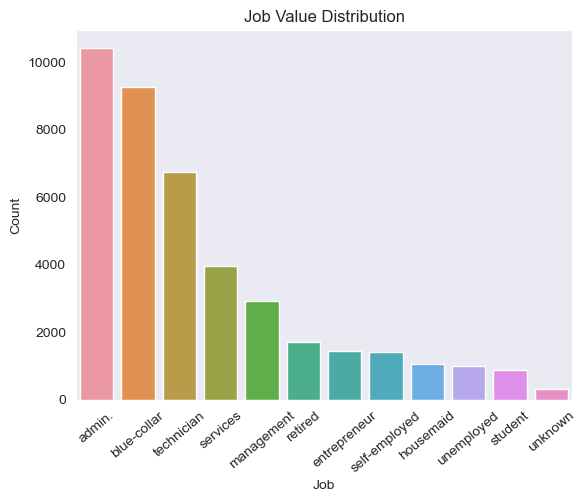

In [188]:
# Find out Job Value Distribution
sns.set_style("dark")
value_counts = df['job'].value_counts()
sns.barplot(x=value_counts.index, y=value_counts.values)
plt.title('Job Value Distribution')
plt.ylabel('Count')
plt.xlabel('Job')
plt.xticks(rotation=40)
plt.show()

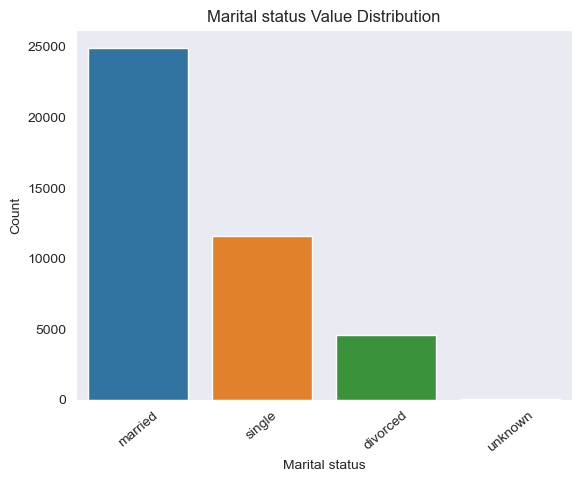

In [189]:
# # Find out Marital Status Value Distribution
sns.set_style("dark")
value_counts = df['marital'].value_counts()
sns.barplot(x=value_counts.index, y=value_counts.values)
plt.title('Marital status Value Distribution')
plt.ylabel('Count')
plt.xlabel('Marital status')
plt.xticks(rotation=40)
plt.show()

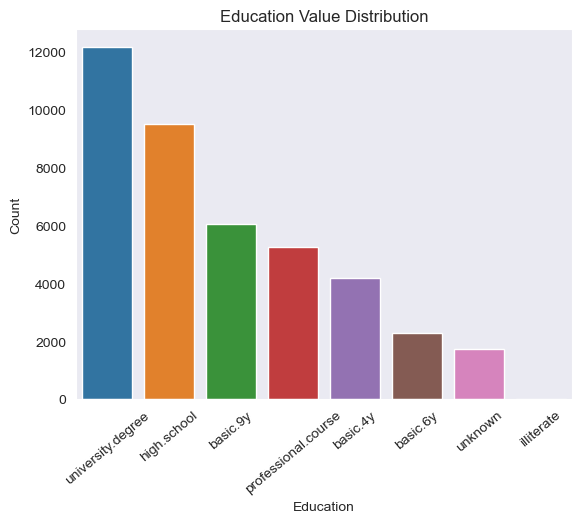

In [190]:
## Find out Education Value Distribution
sns.set_style("dark")
value_counts = df['education'].value_counts()
sns.barplot(x=value_counts.index, y=value_counts.values)
plt.title('Education Value Distribution')
plt.ylabel('Count')
plt.xlabel('Education')
plt.xticks(rotation=40)
plt.show()

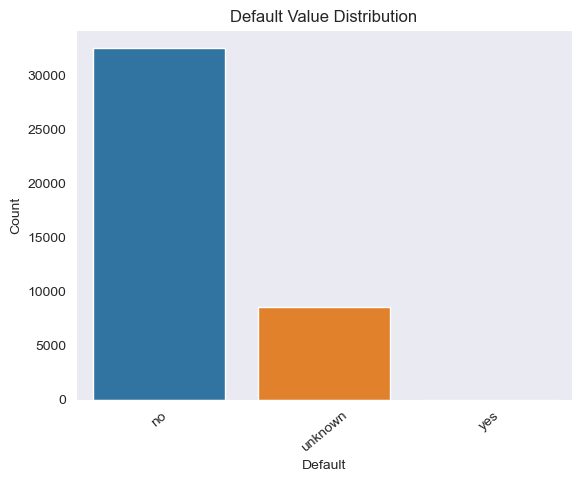

In [191]:
# Find out Default Value Distribution
sns.set_style("dark")
value_counts = df['default'].value_counts()
sns.barplot(x=value_counts.index, y=value_counts.values)
plt.title('Default Value Distribution')
plt.ylabel('Count')
plt.xlabel('Default')
plt.xticks(rotation=40)
plt.show()

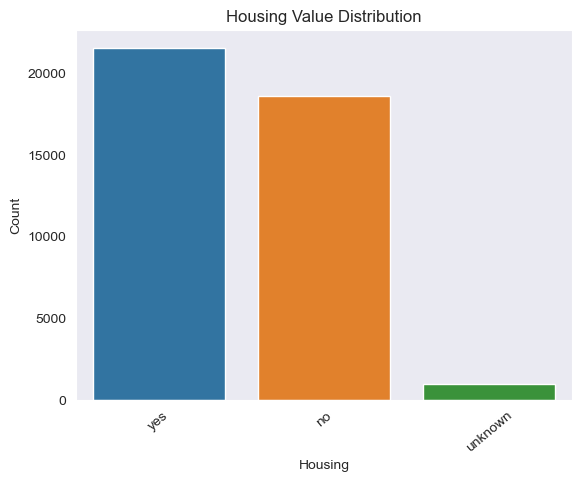

In [192]:
# Find out Housing Value Distribution
sns.set_style("dark")
value_counts = df['housing'].value_counts()
sns.barplot(x=value_counts.index, y=value_counts.values)
plt.title('Housing Value Distribution')
plt.ylabel('Count')
plt.xlabel('Housing')
plt.xticks(rotation=40)
plt.show()

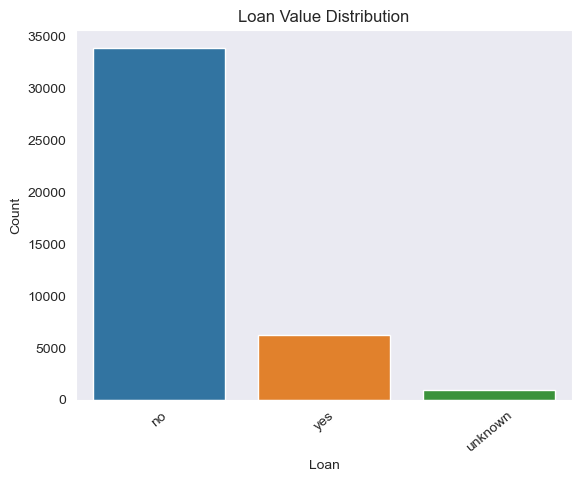

In [193]:
# Find out Loan Value Distribution
sns.set_style("dark")
value_counts = df['loan'].value_counts()
sns.barplot(x=value_counts.index, y=value_counts.values)
plt.title('Loan Value Distribution')
plt.ylabel('Count')
plt.xlabel('Loan')
plt.xticks(rotation=40)
plt.show()

In [194]:
# Columns where 'unknown' values
col_unknown = [col for col in df.columns if df[col].astype(str).eq('unknown').any()]

print("Columns with unknown values:",col_unknown)

Columns with unknown values: ['job', 'marital', 'education', 'default', 'housing', 'loan']


In [195]:
# Find out Value Counts for different features
print(df['job'].value_counts())
print(df['marital'].value_counts())
print(df['education'].value_counts())
print(df['default'].value_counts())
print(df['housing'].value_counts())
print(df['loan'].value_counts())

job
admin.           10419
blue-collar       9253
technician        6739
services          3967
management        2924
retired           1718
entrepreneur      1456
self-employed     1421
housemaid         1060
unemployed        1014
student            875
unknown            330
Name: count, dtype: int64
marital
married     24921
single      11564
divorced     4611
unknown        80
Name: count, dtype: int64
education
university.degree      12164
high.school             9512
basic.9y                6045
professional.course     5240
basic.4y                4176
basic.6y                2291
unknown                 1730
illiterate                18
Name: count, dtype: int64
default
no         32577
unknown     8596
yes            3
Name: count, dtype: int64
housing
yes        21571
no         18615
unknown      990
Name: count, dtype: int64
loan
no         33938
yes         6248
unknown      990
Name: count, dtype: int64


In [196]:
## We are dropping rows which has "unknown" values as those will not help in our model

df = df.drop(df[df['job'] == 'unknown'].index)
df = df.drop(df[df['marital'] == 'unknown'].index)
df = df.drop(df[df['education'] == 'unknown'].index)
df = df.drop(df[df['default'] == 'unknown'].index)
df = df.drop(df[df['housing'] == 'unknown'].index)
df = df.drop(df[df['loan'] == 'unknown'].index)
df.shape

(30478, 21)

In [197]:
## We are dropping default column because mostly the values are "no"
df = df.drop(columns=['default'])
df

,age,job,marital,education,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.10000,93.99400,-36.40000,4.85700,5191.00000,no
2,37,services,married,high.school,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.10000,93.99400,-36.40000,4.85700,5191.00000,no
3,40,admin.,married,basic.6y,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.10000,93.99400,-36.40000,4.85700,5191.00000,no
4,56,services,married,high.school,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.10000,93.99400,-36.40000,4.85700,5191.00000,no
6,59,admin.,married,professional.course,no,no,telephone,may,mon,139,1,999,0,nonexistent,1.10000,93.99400,-36.40000,4.85700,5191.00000,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41183,73,retired,married,professional.course,yes,no,cellular,nov,fri,334,1,999,0,nonexistent,-1.10000,94.76700,-50.80000,1.02800,4963.60000,yes
41184,46,blue-collar,married,professional.course,no,no,cellular,nov,fri,383,1,999,0,nonexistent,-1.10000,94.76700,-50.80000,1.02800,4963.60000,no
41185,56,retired,married,university.degree,yes,no,cellular,nov,fri,189,2,999,0,nonexistent,-1.10000,94.76700,-50.80000,1.02800,4963.60000,no
41186,44,technician,married,professional.course,no,no,cellular,nov,fri,442,1,999,0,nonexistent,-1.10000,94.76700,-50.80000,1.02800,4963.60000,yes


In [198]:
# Find out poutcome Value Distribution
df['poutcome'].value_counts()


poutcome
nonexistent    25826
failure         3461
success         1191
Name: count, dtype: int64

In [199]:
#We will drop poutcome as 85% data is "nonexistent". failure/success is only 15%
df = df.drop(columns=['poutcome'])
df

,age,job,marital,education,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,telephone,may,mon,261,1,999,0,1.10000,93.99400,-36.40000,4.85700,5191.00000,no
2,37,services,married,high.school,yes,no,telephone,may,mon,226,1,999,0,1.10000,93.99400,-36.40000,4.85700,5191.00000,no
3,40,admin.,married,basic.6y,no,no,telephone,may,mon,151,1,999,0,1.10000,93.99400,-36.40000,4.85700,5191.00000,no
4,56,services,married,high.school,no,yes,telephone,may,mon,307,1,999,0,1.10000,93.99400,-36.40000,4.85700,5191.00000,no
6,59,admin.,married,professional.course,no,no,telephone,may,mon,139,1,999,0,1.10000,93.99400,-36.40000,4.85700,5191.00000,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41183,73,retired,married,professional.course,yes,no,cellular,nov,fri,334,1,999,0,-1.10000,94.76700,-50.80000,1.02800,4963.60000,yes
41184,46,blue-collar,married,professional.course,no,no,cellular,nov,fri,383,1,999,0,-1.10000,94.76700,-50.80000,1.02800,4963.60000,no
41185,56,retired,married,university.degree,yes,no,cellular,nov,fri,189,2,999,0,-1.10000,94.76700,-50.80000,1.02800,4963.60000,no
41186,44,technician,married,professional.course,no,no,cellular,nov,fri,442,1,999,0,-1.10000,94.76700,-50.80000,1.02800,4963.60000,yes


In [200]:
# Find out pdays Value Distribution
df['pdays'].value_counts()

pdays
999    29168
3        381
6        363
4        102
2         53
9         53
7         50
12        50
5         43
10        40
13        33
11        25
15        22
1         21
14        17
0         14
8         13
16         8
17         6
18         5
22         3
19         3
21         2
25         1
26         1
27         1
Name: count, dtype: int64

In [201]:
#We will drop pdays as 96% data is "999". other value percentage is only 4%
df = df.drop(columns=['pdays'])
df

,age,job,marital,education,housing,loan,contact,month,day_of_week,duration,campaign,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,telephone,may,mon,261,1,0,1.10000,93.99400,-36.40000,4.85700,5191.00000,no
2,37,services,married,high.school,yes,no,telephone,may,mon,226,1,0,1.10000,93.99400,-36.40000,4.85700,5191.00000,no
3,40,admin.,married,basic.6y,no,no,telephone,may,mon,151,1,0,1.10000,93.99400,-36.40000,4.85700,5191.00000,no
4,56,services,married,high.school,no,yes,telephone,may,mon,307,1,0,1.10000,93.99400,-36.40000,4.85700,5191.00000,no
6,59,admin.,married,professional.course,no,no,telephone,may,mon,139,1,0,1.10000,93.99400,-36.40000,4.85700,5191.00000,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41183,73,retired,married,professional.course,yes,no,cellular,nov,fri,334,1,0,-1.10000,94.76700,-50.80000,1.02800,4963.60000,yes
41184,46,blue-collar,married,professional.course,no,no,cellular,nov,fri,383,1,0,-1.10000,94.76700,-50.80000,1.02800,4963.60000,no
41185,56,retired,married,university.degree,yes,no,cellular,nov,fri,189,2,0,-1.10000,94.76700,-50.80000,1.02800,4963.60000,no
41186,44,technician,married,professional.course,no,no,cellular,nov,fri,442,1,0,-1.10000,94.76700,-50.80000,1.02800,4963.60000,yes


In [202]:
# Find out previous Value Distribution
df['previous'].value_counts()

previous
0    25826
1     3752
2      633
3      190
4       56
5       16
6        4
7        1
Name: count, dtype: int64

In [203]:
#We will drop previous as 85% data is "nonexistent". failure/success is only 15%
df = df.drop(columns=['previous'])
df

,age,job,marital,education,housing,loan,contact,month,day_of_week,duration,campaign,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,telephone,may,mon,261,1,1.10000,93.99400,-36.40000,4.85700,5191.00000,no
2,37,services,married,high.school,yes,no,telephone,may,mon,226,1,1.10000,93.99400,-36.40000,4.85700,5191.00000,no
3,40,admin.,married,basic.6y,no,no,telephone,may,mon,151,1,1.10000,93.99400,-36.40000,4.85700,5191.00000,no
4,56,services,married,high.school,no,yes,telephone,may,mon,307,1,1.10000,93.99400,-36.40000,4.85700,5191.00000,no
6,59,admin.,married,professional.course,no,no,telephone,may,mon,139,1,1.10000,93.99400,-36.40000,4.85700,5191.00000,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41183,73,retired,married,professional.course,yes,no,cellular,nov,fri,334,1,-1.10000,94.76700,-50.80000,1.02800,4963.60000,yes
41184,46,blue-collar,married,professional.course,no,no,cellular,nov,fri,383,1,-1.10000,94.76700,-50.80000,1.02800,4963.60000,no
41185,56,retired,married,university.degree,yes,no,cellular,nov,fri,189,2,-1.10000,94.76700,-50.80000,1.02800,4963.60000,no
41186,44,technician,married,professional.course,no,no,cellular,nov,fri,442,1,-1.10000,94.76700,-50.80000,1.02800,4963.60000,yes


### Problem 4: Understanding the Task

After examining the description and data, your goal now is to clearly state the *Business Objective* of the task.  State the objective below.

In [204]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 30478 entries, 0 to 41187
Data columns (total 17 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             30478 non-null  int64  
 1   job             30478 non-null  object 
 2   marital         30478 non-null  object 
 3   education       30478 non-null  object 
 4   housing         30478 non-null  object 
 5   loan            30478 non-null  object 
 6   contact         30478 non-null  object 
 7   month           30478 non-null  object 
 8   day_of_week     30478 non-null  object 
 9   duration        30478 non-null  int64  
 10  campaign        30478 non-null  int64  
 11  emp.var.rate    30478 non-null  float64
 12  cons.price.idx  30478 non-null  float64
 13  cons.conf.idx   30478 non-null  float64
 14  euribor3m       30478 non-null  float64
 15  nr.employed     30478 non-null  float64
 16  y               30478 non-null  object 
dtypes: float64(5), int64(3), object(9)
m

**Business Objective:**

<font color='blue'>
The primary business objective of this project is to make the Portuguese bank's telemarketing campaign successful. We have to develope a prdictive model which can target customers which are more likely to subscribe these products.

By analysing previous campaigns of the Portuguese bank, we can build and compare different classification models which can accurately find out which clients are more likely to subscribe for the products offered. This prediction can help Portuguese bank to focus it's efforts on specific target audience with greater success rate.
</font>

### Problem 5: Engineering Features

Now that you understand your business objective, we will build a basic model to get started.  Before we can do this, we must work to encode the data.  Using just the bank information features, prepare the features and target column for modeling with appropriate encoding and transformations.

In [205]:
# Encode the outcome variable from yes/no to True/False
df['y'] = df['y'].map({'yes': True, 'no': False}).astype('bool')

In [206]:
AgeRange = {
    (0, 25): '0-25',
    (26, 35): '26-35',    
    (36, 45): '36-45',
    (46, 55): '46-55',    
    (55, 100): '55-100'
}

# Function to map age to age range
def map_age_range(num):
    for val, label in AgeRange.items():
        if val[0] <= num < val[1]:
            return label

# Call the age function
df['AgeRange'] = df['age'].apply(map_age_range)


In [277]:
df['AgeRange'].value_counts()

AgeRange
26-35     10962
36-45      8520
46-55      4863
55-100     2709
0-25        863
Name: count, dtype: int64

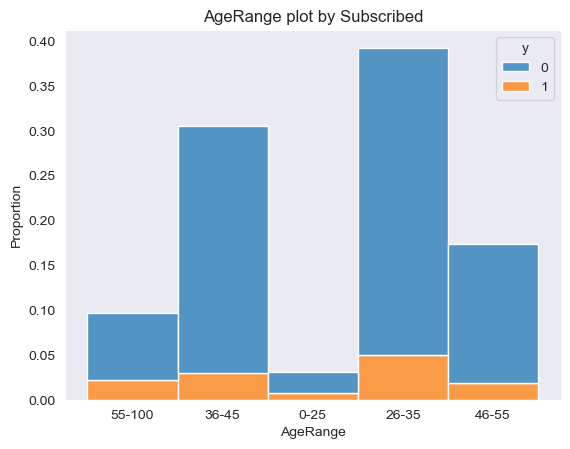

In [281]:
sns.histplot(data = df, x = "AgeRange", hue = "y", 
             multiple = "stack", stat = "proportion").set(title = "AgeRange plot by Subscribed");

In [208]:
#Dropping age as we converted it to ranges
df = df.drop('age', axis=1)


In [209]:
#convert education to numeric
df["education"].replace({"illiterate" : 1, "high.school" : 2, "university.degree" : 3,
                         "basic.4y" : 4, "basic.6y" : 5, "basic.9y" : 6, "professional.course" : 7}, inplace = True)


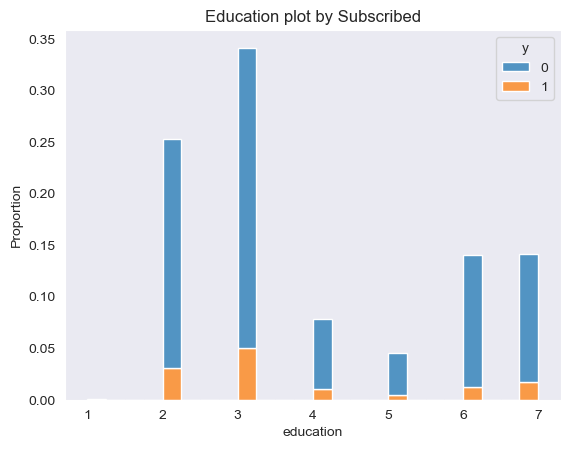

In [283]:
sns.histplot(data = df, x = "education", hue = "y", 
             multiple = "stack", stat = "proportion").set(title = "Education plot by Subscribed");

In [210]:
# Making housing and loan numeric
df['housing'].replace({'yes': 1, 'no': 0}, inplace=True)
df['loan'].replace({'yes': 1, 'no': 0}, inplace=True)

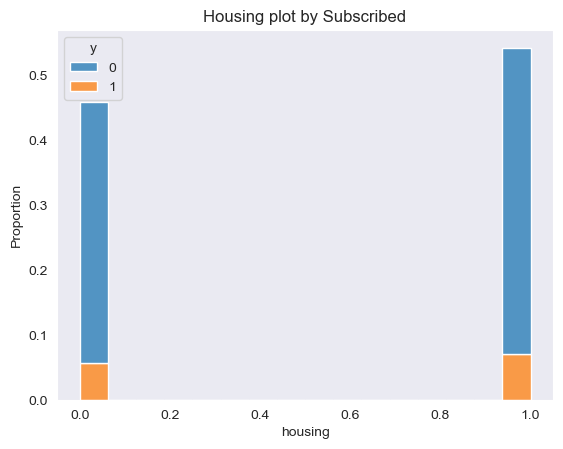

In [286]:
sns.histplot(data = df, x = "housing", hue = "y", 
             multiple = "stack", stat = "proportion").set(title = "Housing plot by Subscribed");

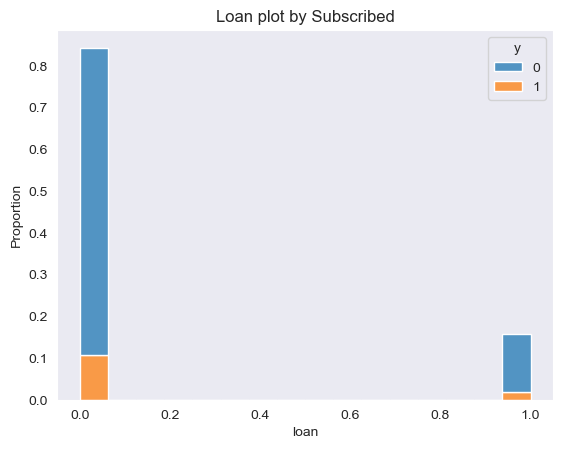

In [285]:
sns.histplot(data = df, x = "loan", hue = "y", 
             multiple = "stack", stat = "proportion").set(title = "Loan plot by Subscribed");

In [211]:
#Convert output column to numeric
df['y'].replace({True: 1, False: 0}, inplace=True)

In [212]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 30478 entries, 0 to 41187
Data columns (total 17 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   job             30478 non-null  object 
 1   marital         30478 non-null  object 
 2   education       30478 non-null  int64  
 3   housing         30478 non-null  int64  
 4   loan            30478 non-null  int64  
 5   contact         30478 non-null  object 
 6   month           30478 non-null  object 
 7   day_of_week     30478 non-null  object 
 8   duration        30478 non-null  int64  
 9   campaign        30478 non-null  int64  
 10  emp.var.rate    30478 non-null  float64
 11  cons.price.idx  30478 non-null  float64
 12  cons.conf.idx   30478 non-null  float64
 13  euribor3m       30478 non-null  float64
 14  nr.employed     30478 non-null  float64
 15  y               30478 non-null  int64  
 16  AgeRange        27917 non-null  object 
dtypes: float64(5), int64(6), object(6)
m

In [213]:
df

,job,marital,education,housing,loan,contact,month,day_of_week,duration,campaign,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y,AgeRange
0,housemaid,married,4,0,0,telephone,may,mon,261,1,1.10000,93.99400,-36.40000,4.85700,5191.00000,0,55-100
2,services,married,2,1,0,telephone,may,mon,226,1,1.10000,93.99400,-36.40000,4.85700,5191.00000,0,36-45
3,admin.,married,5,0,0,telephone,may,mon,151,1,1.10000,93.99400,-36.40000,4.85700,5191.00000,0,36-45
4,services,married,2,0,1,telephone,may,mon,307,1,1.10000,93.99400,-36.40000,4.85700,5191.00000,0,55-100
6,admin.,married,7,0,0,telephone,may,mon,139,1,1.10000,93.99400,-36.40000,4.85700,5191.00000,0,55-100
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41183,retired,married,7,1,0,cellular,nov,fri,334,1,-1.10000,94.76700,-50.80000,1.02800,4963.60000,1,55-100
41184,blue-collar,married,7,0,0,cellular,nov,fri,383,1,-1.10000,94.76700,-50.80000,1.02800,4963.60000,0,46-55
41185,retired,married,3,1,0,cellular,nov,fri,189,2,-1.10000,94.76700,-50.80000,1.02800,4963.60000,0,55-100
41186,technician,married,7,0,0,cellular,nov,fri,442,1,-1.10000,94.76700,-50.80000,1.02800,4963.60000,1,36-45


### Problem 6: Train/Test Split

With your data prepared, split it into a train and test set.

In [214]:
X = df.drop('y', axis=1)
y = df['y']

In [215]:
# Split the datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [216]:
# Shapes of the train and test datasets 
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((21334, 16), (9144, 16), (21334,), (9144,))

### Problem 7: A Baseline Model

Before we build our first model, we want to establish a baseline.  What is the baseline performance that our classifier should aim to beat?

In [217]:
#Create a list of categorical columns
categorical_columns = ['job', 'marital', 'contact','month','day_of_week','AgeRange']

#Treat the rest of columns as numerical
numerical_columns = list(set(X.columns) - set(categorical_columns))
print(numerical_columns)
# Preprocessing pipeline for numerical and categorical features
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_columns),
        ('cat', OneHotEncoder(), categorical_columns)
    ]
)

['housing', 'nr.employed', 'campaign', 'duration', 'cons.price.idx', 'emp.var.rate', 'loan', 'education', 'cons.conf.idx', 'euribor3m']


In [218]:
# Use DummyClassifier for baseline
dummy_model = DummyClassifier(strategy="most_frequent")


dummy_model.fit(X_train, y_train)

# Make predictions
y_pred = dummy_model.predict(X_test)

# Calculate accuracy
baseline_dummy = accuracy_score(y_test, y_pred) 
print(f"Baseline Accuracy is : {baseline_dummy}")

Baseline Accuracy is : 0.8704068241469817


### Problem 8: A Simple Model

Use Logistic Regression to build a basic model on your data.  

In [220]:
# Encode the features again
X_train_enc = preprocessor.fit_transform(X_train)
X_test_enc = preprocessor.fit_transform(X_test)

logistic_reg = LogisticRegression(max_iter=1000, random_state=42)
# Start Time
strt = time.time()

# Fitting the model
logistic_reg.fit(X_train_enc, y_train)

# End Time
end = time.time()

training_time = end - strt

# Make predictions on the training set
y_train_prediction = logistic_reg.predict(X_train_enc)
training_accuracy = accuracy_score(y_train, y_train_prediction)

# Make predictions on the test set
y_test_prediction = logistic_reg.predict(X_test_enc)
testing_accuracy = accuracy_score(y_test, y_test_prediction)

### Problem 9: Score the Model

What is the accuracy of your model?

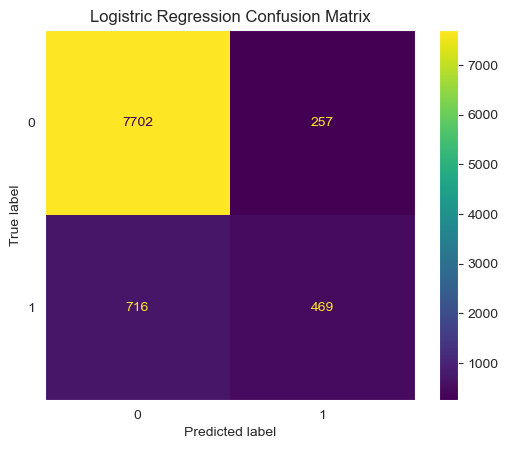

In [221]:
con_mat = confusion_matrix(y_test, y_test_prediction)
con_mat_display = ConfusionMatrixDisplay(confusion_matrix=con_mat)
con_mat_display.plot()
con_mat_display.ax_.set_title("Logistric Regression Confusion Matrix")
plt.show()

In [222]:
# Logistic Regression Model Evaluation
accuracy = accuracy_score(y_test, y_test_prediction)

print(f"Baseline Accuracy: {baseline_dummy}")
print(f"Logistic Regression Accuracy: {accuracy}") 
print(f"Train Accuracy: {training_accuracy:}")
print(f"Test Accuracy: {testing_accuracy:}")
print(f"Train Time: {training_time:.5f} seconds")

Baseline Accuracy: 0.8704068241469817
Logistic Regression Accuracy: 0.893591426071741
Train Accuracy: 0.8951907752882723
Test Accuracy: 0.893591426071741
Train Time: 0.15902 seconds


### Problem 10: Model Comparisons

Now, we aim to compare the performance of the Logistic Regression model to our KNN algorithm, Decision Tree, and SVM models.  Using the default settings for each of the models, fit and score each.  Also, be sure to compare the fit time of each of the models.  Present your findings in a `DataFrame` similar to that below:

| Model | Train Time | Train Accuracy | Test Accuracy |
| ----- | ---------- | -------------  | -----------   |
|     |    |.     |.     |

In [223]:
# KNN Model 

knn = KNeighborsClassifier()

# Start Time
strt = time.time()

# Fitting the model
knn.fit(X_train_enc, y_train)

# End Time
end = time.time()

training_time01 = end - strt

# Make predictions on the training set
y_train_prediction = knn.predict(X_train_enc)
training_accuracy01 = accuracy_score(y_train, y_train_prediction)

# Make predictions on the test set
y_test_prediction = knn.predict(X_test_enc)
testing_accuracy01 = accuracy_score(y_test, y_test_prediction)

# Results 
print(f"KNN Train Accuracy: {training_accuracy01:}")
print(f"KNN Test Accuracy: {testing_accuracy01:}")
print(f"KNN Train Time: {training_time01:.5f} seconds")

KNN Train Accuracy: 0.9170807162276179
KNN Test Accuracy: 0.8860454943132109
KNN Train Time: 0.00263 seconds


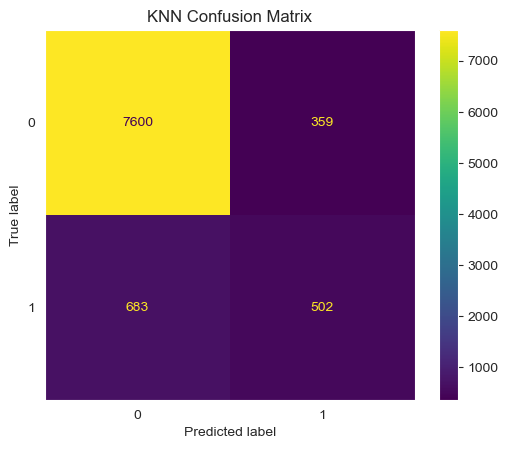

In [224]:
con_mat = confusion_matrix(y_test, y_test_prediction)
con_mat_display = ConfusionMatrixDisplay(confusion_matrix=con_mat)
con_mat_display.plot()
con_mat_display.ax_.set_title("KNN Confusion Matrix")
plt.show()

In [225]:
# Decision Tree Model 

decision_tree = DecisionTreeClassifier(random_state=42)

# Start Time
strt = time.time()

# Fitting the model
decision_tree.fit(X_train_enc, y_train)

# End Time
end = time.time()

training_time02 = end - strt

# Make predictions on the training set
y_train_prediction = decision_tree.predict(X_train_enc)
training_accuracy02 = accuracy_score(y_train, y_train_prediction)

# Make predictions on the test set
y_test_prediction = decision_tree.predict(X_test_enc)
testing_accuracy02 = accuracy_score(y_test, y_test_prediction)

# Results 
print(f"Decision Tree Train Accuracy: {training_accuracy02:}")
print(f"Decision Tree Test Accuracy: {testing_accuracy02:}")
print(f"Decision Tree Train Time: {training_time02:.5f} seconds")

Decision Tree Train Accuracy: 1.0
Decision Tree Test Accuracy: 0.8581583552055994
Decision Tree Train Time: 0.12217 seconds


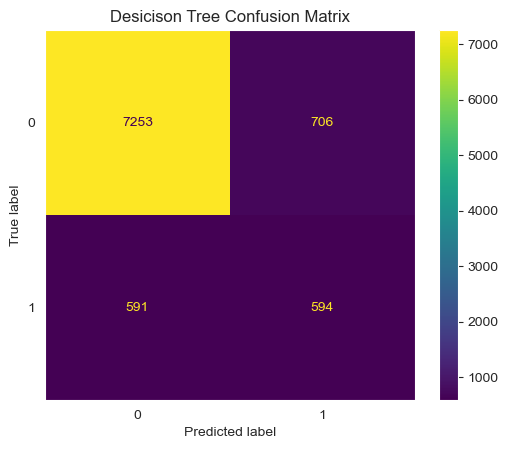

In [226]:
con_mat = confusion_matrix(y_test, y_test_prediction)
con_mat_display = ConfusionMatrixDisplay(confusion_matrix=con_mat)
con_mat_display.plot()
con_mat_display.ax_.set_title("Desicison Tree Confusion Matrix")
plt.show()

In [227]:
# Support Vector Machines Model 

svmm = SVC(random_state=42)

# Start Time
strt = time.time()

# Fitting the model
svmm.fit(X_train_enc, y_train)

# End Time
end = time.time()

training_time03 = end - strt

# Make predictions on the training set
y_train_prediction = svmm.predict(X_train_enc)
training_accuracy03 = accuracy_score(y_train, y_train_prediction)

# Make predictions on the test set
y_test_prediction = svmm.predict(X_test_enc)
testing_accuracy03 = accuracy_score(y_test, y_test_prediction)

# Results 
print(f"Support Vector Machines Model Train Accuracy: {training_accuracy03:}")
print(f"Support Vector Machines Model Test Accuracy: {testing_accuracy03:}")
print(f"Support Vector Machines Model Time: {training_time03:.5f} seconds")

Support Vector Machines Model Train Accuracy: 0.9119715008905972
Support Vector Machines Model Test Accuracy: 0.8968722659667542
Support Vector Machines Model Time: 8.18236 seconds


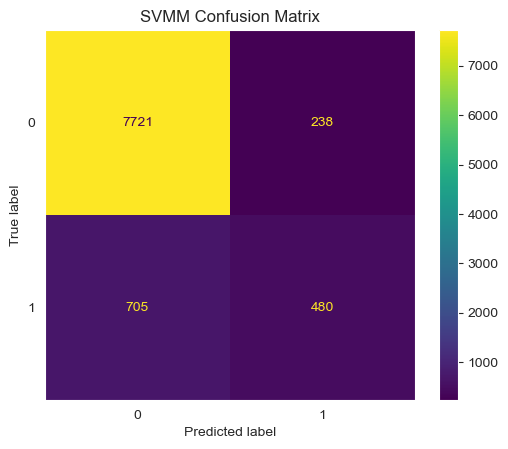

In [228]:
con_mat = confusion_matrix(y_test, y_test_prediction)
con_mat_display = ConfusionMatrixDisplay(confusion_matrix=con_mat)
con_mat_display.plot()
con_mat_display.ax_.set_title("SVMM Confusion Matrix")
plt.show()

In [229]:
findings = pd.DataFrame({
    'Model': ['Logistic Regression', 'KNN', 'Decision Tree', 'SVMM'],
    'Train Time (s)': [training_time, training_time01, training_time02, training_time03],
    'Train Accuracy': [training_accuracy, training_accuracy01, training_accuracy02, training_accuracy03],
    'Test Accuracy': [testing_accuracy, testing_accuracy01, testing_accuracy02, testing_accuracy03]
})
pd.set_option('display.float_format', lambda x: '%.5f' % x)
findings

,Model,Train Time (s),Train Accuracy,Test Accuracy
0,Logistic Regression,0.15902,0.89519,0.89359
1,KNN,0.00263,0.91708,0.88605
2,Decision Tree,0.12217,1.00000,0.85816
3,SVMM,8.18236,0.91197,0.89687


### Problem 11: Improving the Model

Now that we have some basic models on the board, we want to try to improve these.  Below, we list a few things to explore in this pursuit.

- More feature engineering and exploration.  For example, should we keep the gender feature?  Why or why not?
- Hyperparameter tuning and grid search.  All of our models have additional hyperparameters to tune and explore.  For example the number of neighbors in KNN or the maximum depth of a Decision Tree.  
- Adjust your performance metric

***We have cleaned up most of the features by removing unrelated features and converting some non-numeric features to numberic so we will not change our featurelist further. We will use GridSearchCV to find best Hyperparameters for our all 4 classification models. We can pick up best performing model with best performing hyperparameters***

In [230]:
# Finding Best Hyperparameters for Logistic Regression with GridSearchCV

params = {
            'C': [0.01, 0.1, 1, 10],
            'max_iter': [500, 1000, 1500, 2000]
        }

# Classifier
lrc = LogisticRegression(random_state=42)

# Grid Search CV
grid_search = GridSearchCV(estimator=lrc, param_grid=params, cv=5)
start_time = time.time()
grid_search.fit(X_train_enc, y_train)
grid_time = time.time() - start_time
print(grid_search.best_score_)
print(grid_search.best_params_)

0.89495612321954
{'C': 0.1, 'max_iter': 500}


In [231]:
# Finding Best Hyperparameters for KNeighborsClassifier with GridSearchCV

params = {
            'n_neighbors': [5, 10, 20, 25, 30]
        }

# Classifier
knnc = KNeighborsClassifier()

# Grid Search CV
grid_search = GridSearchCV(estimator=knnc, param_grid=params, cv=5)
start_time = time.time()
grid_search.fit(X_train_enc, y_train)
grid_time = time.time() - start_time
print(grid_search.best_score_)
print(grid_search.best_params_)

0.8894722315887987
{'n_neighbors': 20}


In [232]:
# Finding Best Hyperparameters for DecisionTreeClassifier with GridSearchCV

params = {
    'max_depth': [5, 10, 15, 20],
    'min_samples_split': [2, 5, 10],
    'criterion': ['gini', 'entropy'],
    'min_samples_leaf': [1, 2, 4]
}

# Classifier
dtc = DecisionTreeClassifier(random_state=42)

# Grid Search CV
grid_search = GridSearchCV(estimator=dtc, param_grid=params, cv=5)
start_time = time.time()
grid_search.fit(X_train_enc, y_train)
grid_time = time.time() - start_time
print(grid_search.best_score_)
print(grid_search.best_params_)

0.8992686708833292
{'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 2, 'min_samples_split': 2}


In [233]:
# Finding Best Hyperparameters for SVM with GridSearchCV for values of C

params = {
            'C': [0.1, 1, 10]
        }

# Classifier
svmc = SVC(random_state=42)

# Grid Search CV
grid_search = GridSearchCV(estimator=svmc, param_grid=params, cv=5)
start_time = time.time()
grid_search.fit(X_train_enc, y_train)
grid_time = time.time() - start_time
print(grid_search.best_score_)
print(grid_search.best_params_)

0.8962687514194071
{'C': 1}


In [234]:
# Finding Best Hyperparameters for SVM with GridSearchCV for values of gamma

params = {
            'gamma': [0.01, 0.1, 5]
        }

# Classifier
svmc = SVC(random_state=42)

# Grid Search CV
grid_search = GridSearchCV(estimator=svmc, param_grid=params, cv=5)
start_time = time.time()
grid_search.fit(X_train_enc, y_train)
grid_time = time.time() - start_time
print(grid_search.best_score_)
print(grid_search.best_params_)

0.8966906483989308
{'gamma': 0.1}


In [235]:
# Finding Best Hyperparameters for SVM with GridSearchCV for values of kernel

params = {
            'kernel': ['linear', 'rbf', 'poly', 'sigmoid']
        }

# Classifier
svmc = SVC(random_state=42)

# Grid Search CV
grid_search = GridSearchCV(estimator=svmc, param_grid=params, cv=5)
start_time = time.time()
grid_search.fit(X_train_enc, y_train)
grid_time = time.time() - start_time
print(grid_search.best_score_)
print(grid_search.best_params_)

0.8962687514194071
{'kernel': 'rbf'}


**We will compile results from GlideSearchCV results and try to build models with Best Hyperparameters & Adjust our Results in DataFrame**

In [236]:
# Logistic Regression Model with Best Hyperparameters {'C': 0.1, 'max_iter': 500}

logistic_reg = LogisticRegression(C=0.1, max_iter=500, random_state=42)
# Start Time
strt = time.time()

# Fitting the model
logistic_reg.fit(X_train_enc, y_train)

# End Time
end = time.time()

training_time = end - strt

# Make predictions on the training set
y_train_prediction = logistic_reg.predict(X_train_enc)
training_accuracy = accuracy_score(y_train, y_train_prediction)

# Make predictions on the test set
y_test_prediction = logistic_reg.predict(X_test_enc)
testing_accuracy = accuracy_score(y_test, y_test_prediction)

# Results 
print(f"Logistic Regression Train Accuracy: {training_accuracy:}")
print(f"Logistic Regression Test Accuracy: {testing_accuracy:}")
print(f"Logistic Regression Train Time: {training_time:.5f} seconds")

Logistic Regression Train Accuracy: 0.8957532577106966
Logistic Regression Test Accuracy: 0.894575678040245
Logistic Regression Train Time: 0.13052 seconds


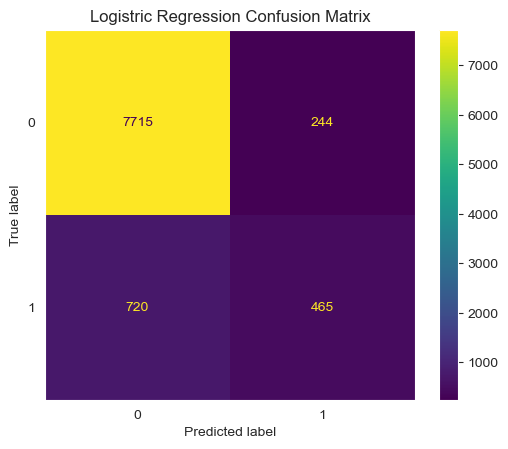

In [237]:
con_mat = confusion_matrix(y_test, y_test_prediction)
con_mat_display = ConfusionMatrixDisplay(confusion_matrix=con_mat)
con_mat_display.plot()
con_mat_display.ax_.set_title("Logistric Regression Confusion Matrix")
plt.show()

In [238]:
# KNN Model with Best Hyperparameters

knn = KNeighborsClassifier(n_neighbors=20)

# Start Time
strt = time.time()

# Fitting the model
knn.fit(X_train_enc, y_train)

# End Time
end = time.time()

training_time01 = end - strt

# Make predictions on the training set
y_train_prediction = knn.predict(X_train_enc)
training_accuracy01 = accuracy_score(y_train, y_train_prediction)

# Make predictions on the test set
y_test_prediction = knn.predict(X_test_enc)
testing_accuracy01 = accuracy_score(y_test, y_test_prediction)

# Results 
print(f"KNN Train Accuracy: {training_accuracy01:}")
print(f"KNN Test Accuracy: {testing_accuracy01:}")
print(f"KNN Train Time: {training_time01:.5f} seconds")

KNN Train Accuracy: 0.8987531639636261
KNN Test Accuracy: 0.8887795275590551
KNN Train Time: 0.00311 seconds


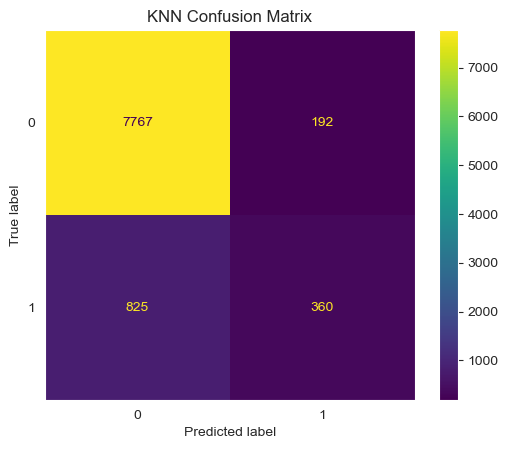

In [239]:
con_mat = confusion_matrix(y_test, y_test_prediction)
con_mat_display = ConfusionMatrixDisplay(confusion_matrix=con_mat)
con_mat_display.plot()
con_mat_display.ax_.set_title("KNN Confusion Matrix")
plt.show()

In [240]:
# Decision Tree Model with Best Hyperparameters :: {'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 2, 'min_samples_split': 2}

decision_tree = DecisionTreeClassifier(criterion='gini', max_depth=5, min_samples_leaf=2, min_samples_split=2, random_state=42)

# Start Time
strt = time.time()

# Fitting the model
decision_tree.fit(X_train_enc, y_train)

# End Time
end = time.time()

training_time02 = end - strt

# Make predictions on the training set
y_train_prediction = decision_tree.predict(X_train_enc)
training_accuracy02 = accuracy_score(y_train, y_train_prediction)

# Make predictions on the test set
y_test_prediction = decision_tree.predict(X_test_enc)
testing_accuracy02 = accuracy_score(y_test, y_test_prediction)

# Results 
print(f"Decision Tree Train Accuracy: {training_accuracy02:}")
print(f"Decision Tree Test Accuracy: {testing_accuracy02:}")
print(f"Decision Tree Train Time: {training_time02:.5f} seconds")

Decision Tree Train Accuracy: 0.9056904471735259
Decision Tree Test Accuracy: 0.8990594925634295
Decision Tree Train Time: 0.05621 seconds


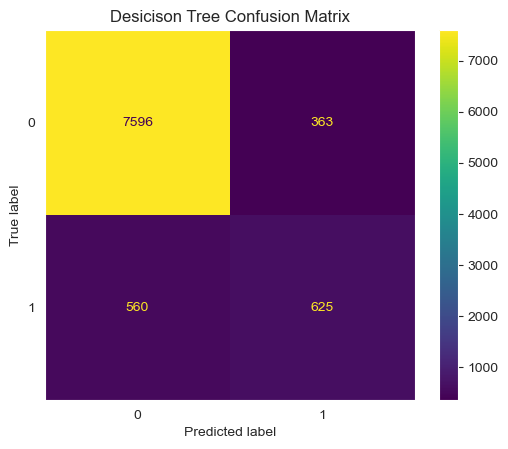

In [241]:
con_mat = confusion_matrix(y_test, y_test_prediction)
con_mat_display = ConfusionMatrixDisplay(confusion_matrix=con_mat)
con_mat_display.plot()
con_mat_display.ax_.set_title("Desicison Tree Confusion Matrix")
plt.show()

In [242]:
# Compiling all 3 best hyperparameters for SVM 

# Support Vector Machines Model 

svmm = SVC(C=1, gamma=0.1, kernel='rbf', random_state=42)

# Start Time
strt = time.time()

# Fitting the model
svmm.fit(X_train_enc, y_train)

# End Time
end = time.time()

training_time03 = end - strt

# Make predictions on the training set
y_train_prediction = svmm.predict(X_train_enc)
training_accuracy03 = accuracy_score(y_train, y_train_prediction)

# Make predictions on the test set
y_test_prediction = svmm.predict(X_test_enc)
testing_accuracy03 = accuracy_score(y_test, y_test_prediction)

# Results 
print(f"Support Vector Machines Model Train Accuracy: {training_accuracy03:}")
print(f"Support Vector Machines Model Test Accuracy: {testing_accuracy03:}")
print(f"Support Vector Machines Model Time: {training_time03:.5f} seconds")

Support Vector Machines Model Train Accuracy: 0.9225649198462548
Support Vector Machines Model Test Accuracy: 0.8958880139982502
Support Vector Machines Model Time: 10.14828 seconds


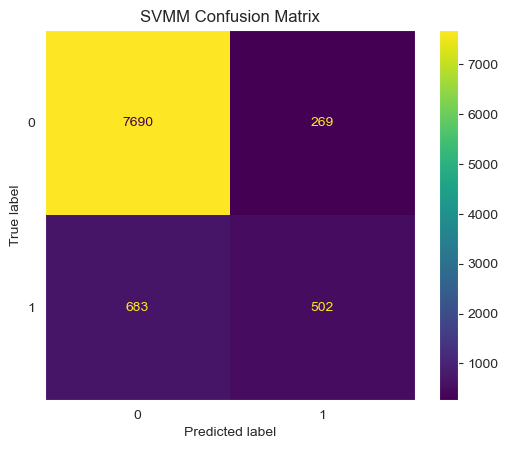

In [243]:
con_mat = confusion_matrix(y_test, y_test_prediction)
con_mat_display = ConfusionMatrixDisplay(confusion_matrix=con_mat)
con_mat_display.plot()
con_mat_display.ax_.set_title("SVMM Confusion Matrix")
plt.show()

**We are now comparing all our Models with Best possible Hyperparameters**

In [246]:
# Findings of Model comparison after we selected Best possible Hyperparameters with GlideSearchCV

findings = pd.DataFrame({
    'Model': ['Logistic Regression', 'KNN', 'Decision Tree', 'SVMM'],
    'Train Time (s)': [training_time, training_time01, training_time02, training_time03],
    'Train Accuracy': [training_accuracy, training_accuracy01, training_accuracy02, training_accuracy03],
    'Test Accuracy': [testing_accuracy, testing_accuracy01, testing_accuracy02, testing_accuracy03]
})
pd.set_option('display.float_format', lambda x: '%.5f' % x)
findings

,Model,Train Time (s),Train Accuracy,Test Accuracy
0,Logistic Regression,0.13052,0.89575,0.89458
1,KNN,0.00311,0.89875,0.88878
2,Decision Tree,0.05621,0.90569,0.89906
3,SVMM,10.14828,0.92256,0.89589


## Results and Next Steps 

### Before the Best Hyperparameters were found : 
1. The best performing model is SVM with 0.89687 test accuracy although it was significantly slow with 8.18 seconds Train Time
2. Logistic Regression was lamost as accurate as SVM with 0.89359 test accuracy and it was very fast with 0.15902 seconds of training time.
3. KNN and Decision tree were at number 3 & 4 with respect to accuracy.
### After the Best Hyperparameters were found by using GridSearchCV:
1. The best performing model is "Decision tree" with test accuracy 0.89906 and training time only 0.05621
2. SVMM & Logistic regression are almos as accurate as Decision tree, but SVMM is very slow with training time of 10.14828 seconds of training time
3. KNN is fastest to train with training time of 0.00311 seconds but it is least accurate with test accuracy of 0.88878

### Observations from data understanding and cleanup, we created various histplots :
1. Most of the customers who subscribed have age group 26~35
2. Most customers who subscribed have University Degree
3. Most customers who subscribed have housing loan
4. Most customers who subscribed have no personal loan